## Instals and Imports

In [1]:
%%capture
# !pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations
import timm 

In [2]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from torch.utils.data import WeightedRandomSampler
        

In [3]:
pl.__version__

'2.1.0'

## Kaggle Score 

In [4]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

## Configuration

In [24]:
class CONFIG:
    
    # == GENERAL ==
    seed = 42                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/effnet_augmented_mixup_backgroundnoise'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 800                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 100                           # min frequency
    max_freq = 16000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 5                               # n fold
    epochs = 20                              # max epochs
    lr = 1e-3                               # learning rate
    weight_decay = 1e-5                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device, ', Using', torch.cuda.device_count(), 'GPU(s)')
pl.seed_everything(CONFIG.seed, workers=True)

Seed set to 42


Device: cuda:0 , Using 1 GPU(s)


42

## Preprocessing

Input: train_metadata.csv

Output: Folder com as os espectrogramas na forma de imagem.

In [26]:
df = pd.read_csv("augmented_only_pl_no_dups_5sec_leq50.csv")
df.head()

# Labels
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['primary_label', 'wav_path']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.primary_label.map(label2id)

# Create Filepath
# train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.wav_path.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [27]:
train_df.shape

(36870, 4)

In [28]:
train_df.head(3)

primary_label                                           wav_path  target  \
0        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
1        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
2        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   

          name  
0   ..-XC11464  
1  ..-XC125026  
2  ..-XC126103

In [29]:
def preprocess_fn(filepath, input_audio = None):

    # LOAD .OGG
    if(input_audio is None):
        input_audio, _ = librosa.load(filepath, sr=CONFIG.sr)
    else:
        input_audio = input_audio
        
    # HANDLE NaNs
    mean_signal = np.nanmean(input_audio)
    input_audio = np.nan_to_num(input_audio, nan=mean_signal) if np.isnan(input_audio).mean() < 1 else np.zeros_like(input_audio)
    
    # SPECTROGRAM
    frequencies, times, spec_data = sci_signal.spectrogram(
        input_audio, 
        fs=CONFIG.sr, 
        nfft=CONFIG.n_fft, 
        nperseg=CONFIG.win_len, 
        noverlap=CONFIG.hop_len, 
        window='hann'
    )
    
    # FILTER LOWER AND HIGHER FREQUENCIES
    valid_freq = (frequencies >= CONFIG.min_freq) & (frequencies <= CONFIG.max_freq)
    spec_data = spec_data[valid_freq, :]
    
    # COMPUTE LOG SPEC
    spec_data = np.log10(spec_data + 1e-20)
    
    # MIN/MAX NORMALIZATION
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    
#     print(spec_data.shape)
    # SPEC TO IMAGE
    spec_data = cv2.resize(spec_data, (256, 256), interpolation=cv2.INTER_AREA)
    
    return spec_data

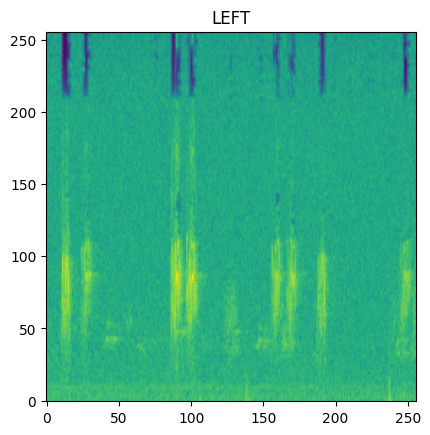

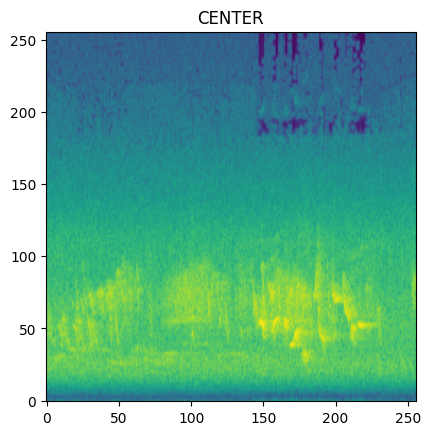

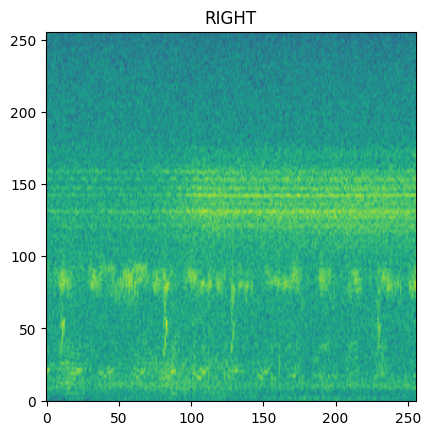

In [30]:
# Just testing

processed_spec_left = preprocess_fn(train_df['wav_path'].values[0])
processed_spec_center = preprocess_fn(train_df['wav_path'].values[1])
processed_spec_right = preprocess_fn(train_df['wav_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [31]:
processed_spec_center.shape

(256, 256)

# Testing augmentations

In [32]:
ex = train_df['wav_path'].values[2]

Audio(ex)

In [33]:
speech, sr = librosa.load(ex, sr = None)
noise, sr = librosa.load('../../data/2024/unlabeled_soundscapes/2002030836.ogg', sr = None)
noise = noise[:sr*5]
# speech_power = speech.norm(p=2)
# noise_power = noise.norm(p=2)
speech_power = np.linalg.norm(speech)
noise_power = np.linalg.norm(noise)
for snr_db in [5]:
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speech = (scale * speech + noise) / 2

In [34]:
scale

1.1070557852348903

In [35]:
Audio(noise, rate = sr)

In [36]:
Audio(noisy_speech, rate = sr)

In [37]:
Audio(speech+noise, rate = sr)

In [38]:
import torchaudio.transforms as T
import torchaudio
import numpy

In [39]:
def play_audio(waveform, sample_rate):
    if type(waveform)!=numpy.ndarray:
        waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else: 
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [40]:
vol=T.Vol(gain=29, gain_type='db')
waveform, sample_rate = torchaudio.load(ex)
play_audio(waveform.numpy(), sample_rate)
waveform1=vol(waveform)
play_audio(waveform1, sample_rate)
gc.collect()

11007

In [41]:
import random
class BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.wav_path.values[numero_aleatorio]
        noise, sample_rate = librosa.load(noise_path, sr = None)
        
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / (1+rand_scale)

        return noisy_speech

In [42]:
!ls ../../preprocessed_data/5sec_unlabeleds_center/

1000170626.wav	1391330745.wav	1785138826.wav	2353770.wav    614656494.wav
1000308629.wav	1391464991.wav	1785930785.wav	235462727.wav  614798601.wav
1000389428.wav	1391863699.wav	1785997129.wav	235583699.wav  614829292.wav
1000424265.wav	1391875653.wav	1786121349.wav	235883008.wav  614921249.wav
1000450112.wav	1392469693.wav	1786216286.wav	235989232.wav  614958223.wav
1000617501.wav	1392768092.wav	178666625.wav	236516966.wav  61503073.wav
100065465.wav	1393025387.wav	1786701443.wav	236676610.wav  615363924.wav
1000771054.wav	1393083844.wav	1787199689.wav	236800088.wav  61545770.wav
1001322634.wav	1393249101.wav	1787221401.wav	236907488.wav  615676016.wav
1001358022.wav	1393303644.wav	1787576477.wav	237277741.wav  615839218.wav
100159753.wav	1393605220.wav	1787670669.wav	237361641.wav  615959305.wav
1001764212.wav	139363125.wav	1787703716.wav	237890815.wav  616589570.wav
1001973321.wav	1393754609.wav	1787710846.wav	23796497.wav   616684483.wav
100238396.wav	1393911465.wav	178778818.wav	2

1281715834.wav	1668290439.wav	2059452026.wav	507414862.wav  888148445.wav
1281893440.wav	1668830431.wav	2059565034.wav	507451447.wav  889114252.wav
1281932953.wav	1669118122.wav	2060052753.wav	507718658.wav  88951245.wav
128261392.wav	1669217663.wav	2060457412.wav	50793300.wav   890126896.wav
128297118.wav	1669852439.wav	2060497515.wav	508309209.wav  8913846.wav
1283065130.wav	1670552696.wav	2060502726.wav	50859202.wav   891773606.wav
1283266002.wav	1670623314.wav	2060840630.wav	508935247.wav  892030865.wav
1283380433.wav	1671001048.wav	2061030487.wav	509545829.wav  892321118.wav
1283459963.wav	1671369347.wav	2061267336.wav	509848179.wav  892501569.wav
1283555218.wav	1671581470.wav	2061398940.wav	50995887.wav   892764242.wav
1283612909.wav	1671747905.wav	2061412473.wav	510912448.wav  892798125.wav
1283692775.wav	1672133296.wav	2061593054.wav	511112936.wav  894054614.wav
1283835160.wav	1672183811.wav	2061696164.wav	511321363.wav  894282042.wav
128387498.wav	1672283577.wav	2062082115.wav

In [43]:
Audio('../../preprocessed_data/5sec_unlabeleds_center/783268773.wav')

In [44]:
list_augs = os.listdir('../../preprocessed_data/5sec_unlabeleds_center/')
list_augs = ['../../preprocessed_data/5sec_unlabeleds_center/' + w for w in list_augs]

ex_df = pd.DataFrame({'wav_path': list_augs})

In [45]:
ex_df.shape

(8444, 1)

In [46]:
y , sr = librosa.load(ex_df.wav_path[1], sr = None)
print(sr, y.shape)
Audio(y, rate = sr)

32000 (160000,)


In [47]:
y , sr = librosa.load(train_df.wav_path[1], sr = None)
print(sr, y.shape)
Audio(y, rate = sr)

32000 (160000,)


In [48]:
backaud = BackgroundAugmentation(1.5,1.5, ex_df)

In [49]:
waveform, sample_rate = librosa.load(ex, sr = None)
waveform = backaud(waveform)
Audio(waveform, rate = sample_rate)

In [51]:
waveform.shape

(160000,)

In [52]:
waveform, sample_rate = librosa.load(ex)
waveform.shape

(110250,)

In [53]:
# if not CONFIG.preprocess:
#     all_bird_data = np.load(f'{CONFIG.preprocessed_data}/spec_center_5sec_256_256.npy', allow_pickle=True).item()
# else:
#     all_bird_data = dict()
#     for i, row_metadata in tqdm(train_df.iterrows()):
        
#         # filepath to processed spec img center, left and right
#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'center')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'left')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'right')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)
    
#     # save to file
#     np.save(os.path.join(CONFIG.preprocessed_data, f'spec_3sides_5sec_256_256.npy'), all_bird_data)

## Dataset

In [54]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        df,
        aud_augmentation = None,
        spec_augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.df = df
        self.aud_augmentation = aud_augmentation
        self.spec_augmentation = spec_augmentation
        self.mode = mode
        self.labels = np.eye(182)[self.df["target"].astype(int).values]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        wav_path = self.df.wav_path.values[index]
        
        # load spec. data
        input_audio, sr = librosa.load(wav_path, sr = None) 
        
        # aug
        if self.aud_augmentation is not None:
#             print(input_audio.shape)
            input_audio = self.aud_augmentation(input_audio)
        
        input_spec = preprocess_fn('', input_audio = input_audio)
        
        if self.spec_augmentation is not None:
            input_spec = self.spec_augmentation(image=input_spec)['image']
        
        # target
        target = self.labels[index]
        
        
#         return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)
        return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))

In [55]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.GaussNoise(var_limit=(0.001, 0.01), mean=0),
#             albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 5),
                num_masks_y=(1, 3),
                mask_x_length=(1, 20),
                mask_y_length=(1, 5),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [56]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label.argmax()}')
    
    plt.tight_layout()
    plt.show()

In [57]:
train_df

primary_label                                           wav_path  \
0            barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...   
1            barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...   
2            barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...   
3            barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...   
4            barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...   
...             ...                                                ...   
36865       zitcis1  ../../preprocessed_data/5sec_wavs_augmented/zi...   
36866       zitcis1  ../../preprocessed_data/5sec_wavs_augmented/zi...   
36867       zitcis1  ../../preprocessed_data/5sec_wavs_augmented/zi...   
36868       zitcis1  ../../preprocessed_data/5sec_wavs_augmented/zi...   
36869       zitcis1  ../../preprocessed_data/5sec_wavs_augmented/zi...   

       target                 name  
0           9           ..-XC11464  
1           9          ..-XC125026  
2           9          ..-XC126103  
3           9          ..-XC129647  
4           9          ..-XC132406  
...       ...                  ...  
36865     181  ..-zitcis1_XC845747  
36866     181  ..-zitcis1_XC845817  
36867     181  ..-zitcis1_XC856176  
36868     181  ..-zitcis1_XC856723  
36869     181  ..-zitcis1_XC858550  

[36870 rows x 4 columns]

(256, 256)


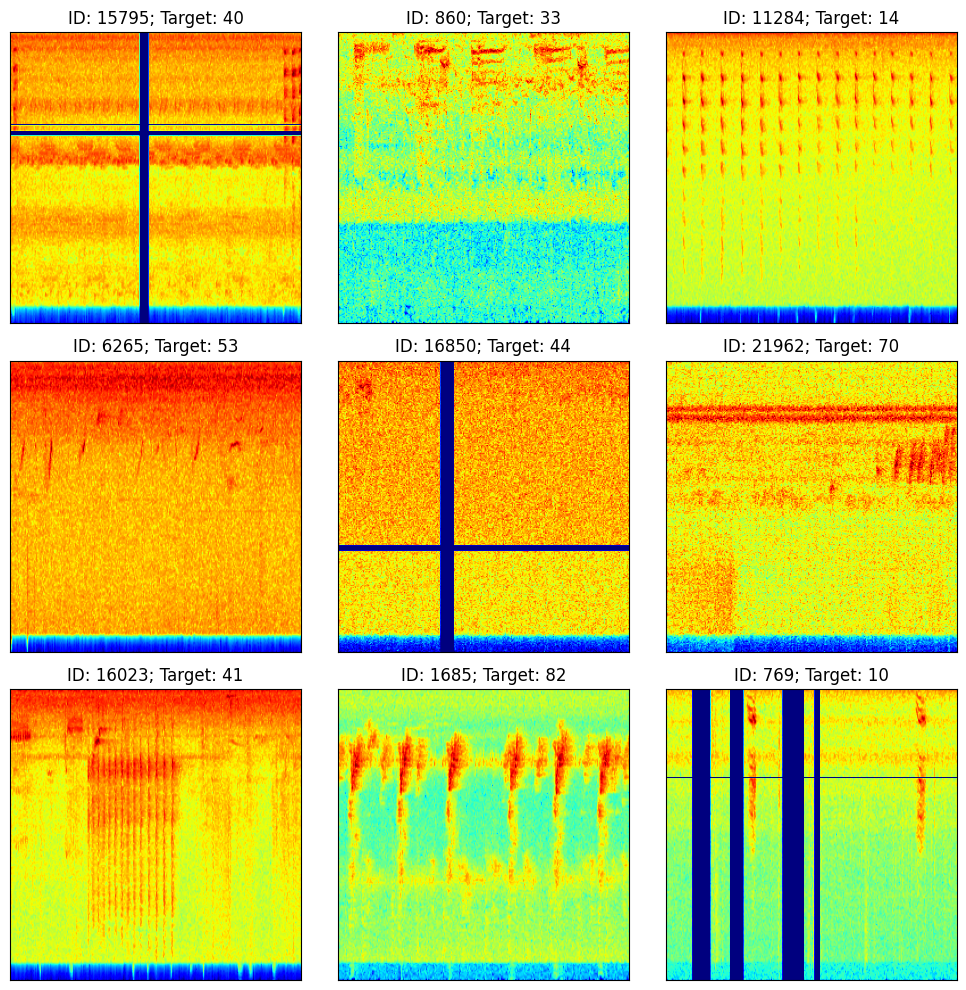

27268

In [58]:
dummy_dataset = BirdDataset(train_df, backaud , get_transforms('train'))

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()


## Cross-Validation

In [59]:
kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df['target'])):
    for idx in val_idx:
        train_df.iloc[idx, train_df.columns.get_loc('fold') ] = fold

In [60]:
train_df.fold.value_counts()

3    7374
4    7374
2    7374
1    7374
0    7374
Name: fold, dtype: int64

## Model

In [62]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(1)
#         x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        x = x.expand(-1, 3, -1, -1)
        return self.base_model(x)
    

In [63]:
## RUN THIS IF ERROR IN IMPORTING EFFNET WEIGTHS
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

In [65]:
%%time
dummy_model = EffNet(CONFIG.model, n_classes=len(label_list))

dummy_input = torch.randn(64, 256, 256)
print(dummy_model(dummy_input).shape)


torch.Size([64, 182])
CPU times: user 39.4 s, sys: 15.9 s, total: 55.3 s
Wall time: 2.34 s


In [108]:
from torch.distributions import Beta
class Mixup(nn.Module):
    def __init__(self, mix_beta):

        super(Mixup, self).__init__()
        self.beta_distribution = Beta(mix_beta, mix_beta)

    def forward(self, X, Y, weight=None):

        bs = X.shape[0]
        n_dims = len(X.shape)
        perm = torch.randperm(bs)
        coeffs = self.beta_distribution.rsample(torch.Size((bs,))).to(X.device)

        if n_dims == 2:
            X = coeffs.view(-1, 1) * X + (1 - coeffs.view(-1, 1)) * X[perm]
        elif n_dims == 3:
            X = coeffs.view(-1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1)) * X[perm]
        else:
            X = coeffs.view(-1, 1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1, 1)) * X[perm]

        Y = coeffs.view(-1, 1) * Y + (1 - coeffs.view(-1, 1)) * Y[perm]

#         print(coeffs)
        if weight is None:
            return X, Y
        else:
            weight = coeffs.view(-1) * weight + (1 - coeffs.view(-1)) * weight[perm]
            return X, Y, weight

In [109]:
mixup = Mixup(0.5)

In [110]:
a, b = mixup(test_input.unsqueeze(0), test_target.unsqueeze(0))

In [111]:
a.shape, b.shape

(torch.Size([1, 256, 256]), torch.Size([1, 182]))

In [112]:
b

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

## Lightning Module

In [113]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(CONFIG.model, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
#         self.loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    
        self.mixup = Mixup(mix_beta=0.5)
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
#         num_classes = 182

        
        image, target = self.mixup(image, target)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # target to one-hot
#         target_val = torch.nn.functional.one_hot(target_val, len(label_list)).float()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

## Training Loop

In [114]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
#     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [115]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df[f'fold'] != fold_id].copy()
    valid_df = total_df[total_df[f'fold'] == fold_id].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    # == create a sampler that samples inversely of its counts ==
    y_train = train_df['target']
#     class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
#     weight = 1. / class_sample_count
#     samples_weight = np.array([weight[t] for t in y_train])
#     samples_weight = torch.from_numpy(samples_weight)
    
#     sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
    
    backaud = BackgroundAugmentation(1.5,1.5, ex_df)
    backaud_valid = BackgroundAugmentation(0.1,0.1, ex_df)
    
    train_ds = BirdDataset(train_df, backaud, get_transforms('train'), 'train')
    val_ds = BirdDataset(valid_df, backaud_valid, get_transforms('valid'), 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=True, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
#         sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

## RUN

In [116]:
train_df.head(), train_df.target.nunique()

(  primary_label                                           wav_path  target  \
 0        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
 1        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
 2        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
 3        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
 4        barswa  ../../preprocessed_data/5sec_wavs_augmented/XC...       9   
 
           name  fold  
 0   ..-XC11464     3  
 1  ..-XC125026     4  
 2  ..-XC126103     4  
 3  ..-XC129647     4  
 4  ..-XC132406     2  ,
 182)

In [ ]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


==== Running training for fold 0 ====
Train Samples: 29496
Valid Samples: 7374


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

In [ ]:
import tqdm
tqdm.__version__

In [ ]:
from tqdm.auto import tqdm

In [ ]:
!pip install ipywidgets

In [63]:

for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

Fold 0 Val Score: 0.89394
Fold 1 Val Score: 0.90372
Fold 2 Val Score: 0.89486
Fold 3 Val Score: 0.88803
Fold 4 Val Score: 0.88864


In [66]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]
ckpt_list

find 5 ckpts in ../chpks/effnet_mixup_backgroundnoise.


['../chpks/effnet_mixup_backgroundnoise/fold_2.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_3.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_4.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_1.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_0.ckpt']

In [ ]:
ex = '../chpks/effnet_5fold_kfold/fold_0.ckpt'

In [ ]:
c1 = torch.load(ckpt_list[0], map_location=torch.device('cpu'))['state_dict']
c2 = torch.load(ex, map_location=torch.device('cpu'))['state_dict']

In [ ]:
for k1 in c1.keys():
    if k1 not in c2.keys():
        print('k1 is not')
        if(c1[k1].dtype != c2[k1].dtype):
            print('not same type ', k1)

In [ ]:
for chave in c1.keys():
    tensor1_shape = c1[chave].shape
    tensor2_shape = c2[chave].shape
    if tensor1_shape != tensor2_shape:
        print(f"As dimensões do tensor '{chave}' são diferentes nos dois checkpoints:")
        print(f"Checkpoint 1: {tensor1_shape}")
        print(f"Checkpoint 2: {tensor2_shape}")

In [ ]:
c1 = torch.load(ckpt_list[0], map_location=torch.device('cpu'))
c2 = torch.load(ex, map_location=torch.device('cpu'))

In [ ]:
c1.keys()

In [ ]:
c1['loops']

In [ ]:
c1['pytorch-lightning_version']

In [ ]:
c2['pytorch-lightning_version']

In [64]:
# == setting of onnx ==

input_tensor = torch.randn(64, 256, 256)  # input shape
input_names = ['x']
output_names = ['output']

In [68]:
onnx_ckpt_list = list()
for ckpt_path in ckpt_list:
    ckpt_name = os.path.basename(ckpt_path).split('.')[0]
    # == init model ==
    bird_model = BirdModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    bird_model.eval()
    
    # == convert to onnx ==
    torch.onnx.export(bird_model.backbone, input_tensor, f"{CONFIG.checkpoint_dir}/{ckpt_name}.onnx", verbose=False, input_names=input_names, output_names=output_names)
#     onnx_ckpt_list.append(f"{ckpt_name}.onnx")

In [ ]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

In [ ]:

for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')


In [ ]:
len(val_gts)